Autor: Kevyn A. Marcelino  
Data: 2023-07-10


### Objetivo do código 
**Gerar automaticamente os tickers usados para as carteiras de gradiente e algoritmo genético.**

Lógica:

- 1. Obter os tickers de cada setor da B3
- 2. Obter o mktpcap de cada ticker
- 3. Escolher os tickers com maior mktpcap de cada setor para maior diversificação



## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
from io import BytesIO
import json
from bs4 import BeautifulSoup
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

### 1. Obtendo tickers e setores direto da B3


In [2]:


# Lendo arquivo zip diretamente do site da B3
url_setores = 'https://www.b3.com.br/data/files/57/E6/AA/A1/68C7781064456178AC094EA8/ClassifSetorial.zip'

r = requests.get(url_setores)
z = zipfile.ZipFile(BytesIO(r.content))

# lendo arquivo xlsx dentro do zip
df = pd.read_excel(z.open(z.namelist()[0]), skiprows=5, skipfooter=15)

# Outra forma de pegar os nomes das colunas de forma mais automática - acabei substituindo pela lista "cols" abaixo, mas esse também funciona
# df.iloc[:2] = df.iloc[:2].fillna(method='ffill')
# df.columns = df.iloc[1]
cols = ['setor_economico', 'subsetor', 'empresa', 'codigo', 'listagem']
df.columns = cols

# Encontrar última linha com valor na coluna 'Código' -> Lógica é limpar rodapé do arquivo (que contém informações sobre a fonte dos dados e um dicionário)
last_row = df[df['codigo'].notnull()].index[-1] + 1
df = df.iloc[2:last_row]

# Tratamentos

df = df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip() if x.dtype == 'object' else x) # Tirando acentos e espaços em branco
# Criando outra coluna para o segmento, agora está na coluna 'empresa' 
df.insert(2, 'segmento', df['empresa'])
df['segmento'] = np.where(df['codigo'].isna(), df['segmento'], np.nan) # deixar valor do segmento se valor na coluna 'setor_economico' não for nulo, senão deixar nulo
# Preenchendo nulos e filtros restantes
df[['setor_economico', 'subsetor', 'segmento']] = df[['setor_economico', 'subsetor', 'segmento']].fillna(method='ffill')
setores = df[(df['segmento'] != df['empresa']) & (df['setor_economico'] != 'SETOR ECONOMICO') & (df['empresa'].notna())]
print(setores.shape)
setores.head(50)


(448, 6)


,setor_economico,subsetor,segmento,empresa,codigo,listagem
3,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",3R PETROLEUM,RRRP,NM
4,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",COSAN,CSAN,NM
5,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",ENAUTA PART,ENAT,NM
6,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",PET MANGUINH,RPMG,NaN
7,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",PETROBRAS,PETR,N2
8,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",PETRORECSA,RECV,NM
9,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",PETRORIO,PRIO,NM
10,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",ULTRAPAR,UGPA,NM
11,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",VIBRA,VBBR,NM
13,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis",Equipamentos e Servicos,LUPATECH,LUPA,NM


In [3]:
# Checando distribuição dos setores
setores['setor_economico'].value_counts(normalize=True)
# ver o percentual que representa cada setor em questão de mkt cap

Consumo Ciclico                    0.200893
Financeiro                         0.183036
Bens Industriais                   0.162946
Utilidade Publica                  0.145089
Materiais Basicos                  0.069196
Consumo nao Ciclico                0.069196
Saude                              0.051339
Tecnologia da Informacao           0.042411
Outros                             0.029018
Petroleo, Gas e Biocombustiveis    0.026786
Comunicacoes                       0.020089
Name: setor_economico, dtype: float64

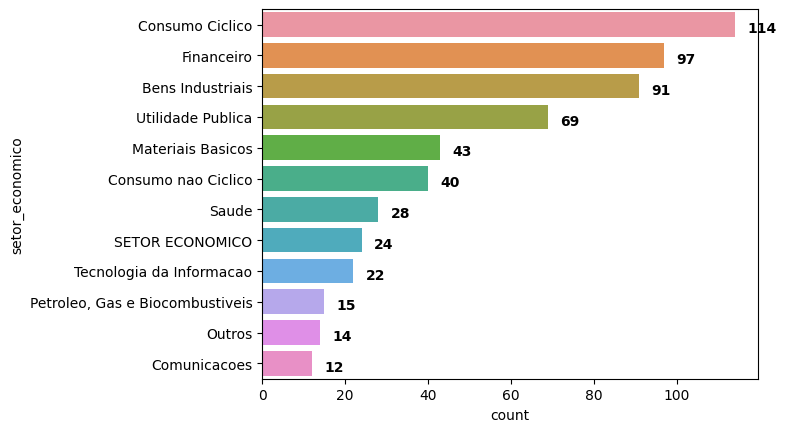

In [4]:
sns.countplot(y='setor_economico', data=df, order=df['setor_economico'].value_counts().index)
# inserir número de empresas em cada barra
for i, v in enumerate(df['setor_economico'].value_counts()):
    plt.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    

### 2. Obtendo mktpcap de cada ticker

Manipulando o código de base 64 para conseguir ler toda a página de uma vez - a idéia é mudar o parâmetro "pageSize" que limita o número máximo de empresas mostradas

In [5]:
from base64 import b64decode
from base64 import b64encode

# String obtida no json da requisição dos site da B3
string = b64decode('eyJsYW5ndWFnZSI6InB0LWJyIiwiY29tcGFueSI6IiIsImtleXdvcmQiOiIiLCJwYWdlTnVtYmVyIjoxLCJwYWdlU2l6ZSI6MTIwfQ==').decode('utf-8')
string

'{"language":"pt-br","company":"","keyword":"","pageNumber":1,"pageSize":120}'

In [6]:
# Alternando parâmetro e codificando novamente para nova requisição - Testes
string = b64encode(b'{"name":"","pageNumber":1,"pageSize":9999}').decode()
#url_personalizada = 'https://sistemaswebb3-listados.b3.com.br/shareCapitalProxy/ShareCapitalCall/GetList/' + string # teste
url_personalizada = 'https://sistemaswebb3-listados.b3.com.br/marketValueProxy/marketValueCall/GetStockExchangeDaily/' + string
string
#string

'eyJuYW1lIjoiIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjk5OTl9'

In [7]:
# Request direto da B3 - url alterado
url = 'https://sistemaswebb3-listados.b3.com.br/marketValueProxy/marketValueCall/GetStockExchangeDaily/eyJsYW5ndWFnZSI6InB0LWJyIiwiY29tcGFueSI6IiIsImtleXdvcmQiOiIiLCJwYWdlTnVtYmVyIjoxLCJwYWdlU2l6ZSI6MTIwfQ=='

r = requests.get(url)
r.content

b'{"Header":{"TimeStamp":"2023-07-10T22:22:54.1031889-03:00","Row":"[00000001] / [00000002]","Date":"2023-07-08T00:00:00","Column000":"IBOV","Column001":"IBRX100","Column002":"Empresa","Column003":"R$ (Mil)","Column004":"Var.(%) em rela\\u00E7\\u00E3o a 30/06/2023","Column005":"USD (Mil)","Column006":"Var.(%) em rela\\u00E7\\u00E3o a 30/06/2023"},"Body":[{"Row":"[00000003]","Column000":"*","Column001":"**","Column002":"3R PETROLEUM","Column003":"7.736.692,67","Column004":"8,04%","Column005":"1.585.420,33","Column006":"6,70%"},{"Row":"[00000004]","Column000":"","Column001":"","Column002":"3TENTOS","Column003":"6.741.967,16","Column004":"5,29%","Column005":"1.381.578,96","Column006":"3,98%"},{"Row":"[00000005]","Column000":"","Column001":"","Column002":"ABC BRASIL","Column003":"4.101.274,74","Column004":"-4,88%","Column005":"840.442,37","Column006":"-6,06%"},{"Row":"[00000006]","Column000":"","Column001":"","Column002":"ACO ALTONA","Column003":"184.410,00","Column004":"0,56%","Column005"

In [8]:
data = pd.json_normalize(json.loads(r.content))
data

,Body,Footer,Header.TimeStamp,Header.Row,Header.Date,Header.Column000,Header.Column001,Header.Column002,Header.Column003,Header.Column004,Header.Column005,Header.Column006
0,"[{'Row': '[00000003]', 'Column000': '*', 'Colu...","[{'Row': '[00000379]', 'Column000': '', 'Colum...",2023-07-10T22:22:54.1031889-03:00,[00000001] / [00000002],2023-07-08T00:00:00,IBOV,IBRX100,Empresa,R$ (Mil),Var.(%) em relação a 30/06/2023,USD (Mil),Var.(%) em relação a 30/06/2023


In [9]:
data_final = pd.to_datetime(data['Header.TimeStamp'][0]).strftime('%Y-%m-%d')
print(f'Data do arquivo: {data_final}')


Data do arquivo: 2023-07-10


In [10]:
columns = data.iloc[0, 5:].to_list()
# deixar tudo em letra minúscula e substituir espaços por underline
columns = [x.lower().replace(' ', '_') for x in columns]
columns

['ibov',
 'ibrx100',
 'empresa',
 'r$_(mil)',
 'var.(%)_em_relação_a_30/06/2023',
 'usd_(mil)',
 'var.(%)_em_relação_a_30/06/2023']

In [11]:
body =  pd.json_normalize(json.loads(r.content), record_path =['Body'])
body

,Row,Column000,Column001,Column002,Column003,Column004,Column005,Column006
0,[00000003],*,**,3R PETROLEUM,"7.736.692,67","8,04%","1.585.420,33","6,70%"
1,[00000004],,,3TENTOS,"6.741.967,16","5,29%","1.381.578,96","3,98%"
2,[00000005],,,ABC BRASIL,"4.101.274,74","-4,88%","840.442,37","-6,06%"
3,[00000006],,,ACO ALTONA,"184.410,00","0,56%","37.789,71","-0,69%"
4,[00000007],,,AERIS,"1.042.050,30","2,26%","213.539,27","0,98%"
...,...,...,...,...,...,...,...,...
371,[00000374],,,WIZ CO,"1.037.798,26","3,02%","212.667,94","1,73%"
372,[00000375],,,WLM IND COM,"722.872,09","-2,18%","148.132,56","-3,39%"
373,[00000376],,,YBYRA S/A,"0,00","0,00%","0,00","0,00%"
374,[00000377],*,**,YDUQS PART,"6.181.777,02","0,91%","1.266.783,54","-0,35%"


In [12]:
if body.empty:
    print(f'Arquivo da data {data_final} vazio!')

In [13]:
footer =  pd.json_normalize(json.loads(r.content), record_path =['Footer'])
footer

,Row,Column000,Column001,Column002,Column003,Column004,Column005,Column006
0,[00000379],,,TOTAL (IBOV),"3.713.939.669,18","0,21%","761.068.806,58","-1,04%"
1,[00000380],,,TOTAL (IBXX),"3.850.638.688,17","0,28%","789.081.474,66","-0,97%"
2,[00000381],,,TOTAL GERAL 376,"4.455.349.979,18","0,39%","913.000.262,14","-0,86%"


In [14]:
mkt_cap = pd.concat([body, footer]).reset_index(drop=True)
mkt_cap.drop(columns=['Row'], inplace=True)
mkt_cap.columns = columns
mkt_cap = mkt_cap.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip() if x.dtype == 'object' else x) # Tirando acentos e espaços em branco
mkt_cap

,ibov,ibrx100,empresa,r$_(mil),var.(%)_em_relação_a_30/06/2023,usd_(mil),var.(%)_em_relação_a_30/06/2023
0,*,**,3R PETROLEUM,"7.736.692,67","8,04%","1.585.420,33","6,70%"
1,,,3TENTOS,"6.741.967,16","5,29%","1.381.578,96","3,98%"
2,,,ABC BRASIL,"4.101.274,74","-4,88%","840.442,37","-6,06%"
3,,,ACO ALTONA,"184.410,00","0,56%","37.789,71","-0,69%"
4,,,AERIS,"1.042.050,30","2,26%","213.539,27","0,98%"
...,...,...,...,...,...,...,...
374,*,**,YDUQS PART,"6.181.777,02","0,91%","1.266.783,54","-0,35%"
375,,,ZAMP S.A.,"1.280.402,83","2,20%","262.383,01","0,93%"
376,,,TOTAL (IBOV),"3.713.939.669,18","0,21%","761.068.806,58","-1,04%"
377,,,TOTAL (IBXX),"3.850.638.688,17","0,28%","789.081.474,66","-0,97%"


In [15]:
mkt_cap.iloc[:, [3,5]] = mkt_cap.iloc[:, [3,5]].apply(lambda x: x.str.replace('.','').str.replace(',','.')).astype(float)
mkt_cap.iloc[:, [4,6]] = mkt_cap.iloc[:, [4,6]].apply(lambda x: x.str.replace('%','').str.replace(',','.')).astype(float)#.apply(lambda x: x/100)
mkt_cap


,ibov,ibrx100,empresa,r$_(mil),var.(%)_em_relação_a_30/06/2023,usd_(mil),var.(%)_em_relação_a_30/06/2023
0,*,**,3R PETROLEUM,7736692.67,8.04,1585420.33,6.7
1,,,3TENTOS,6741967.16,5.29,1381578.96,3.98
2,,,ABC BRASIL,4101274.74,-4.88,840442.37,-6.06
3,,,ACO ALTONA,184410.0,0.56,37789.71,-0.69
4,,,AERIS,1042050.3,2.26,213539.27,0.98
...,...,...,...,...,...,...,...
374,*,**,YDUQS PART,6181777.02,0.91,1266783.54,-0.35
375,,,ZAMP S.A.,1280402.83,2.2,262383.01,0.93
376,,,TOTAL (IBOV),3713939669.18,0.21,761068806.58,-1.04
377,,,TOTAL (IBXX),3850638688.17,0.28,789081474.66,-0.97


### 3. Juntando setores com mkt cap e escolhendo os tickers com maior mktpcap de cada setor

In [16]:
# Setando 2 casas decimais, para corrigir bug de notação científica
pd.options.display.float_format = '{:.2f}'.format

# Juntando setores com market cap e tratamentos finais
merge = setores.merge(mkt_cap[['empresa', 'r$_(mil)']], on='empresa', how='left')
merge['r$_(mil)'].fillna(0, inplace=True)

# Ordenar maior marketcap por setor economico
merge.sort_values(by=['setor_economico', 'r$_(mil)'], ascending=[True, False], inplace=True)

merge

,setor_economico,subsetor,segmento,empresa,codigo,listagem,r$_(mil)
57,Bens Industriais,Maquinas e Equipamentos,"Motores, Compressores e Outros",WEG,WEGE,NM,155300765.93
77,Bens Industriais,Transporte,Transporte Ferroviario,RUMO S.A.,RAIL,NM,42126487.73
84,Bens Industriais,Transporte,Exploracao de Rodovias,CCR SA,CCRO,NM,27835600.00
48,Bens Industriais,Material de Transporte,Material Aeronautico e de Defesa,EMBRAER,EMBR,NM,13498677.75
108,Bens Industriais,Servicos Diversos,Servicos Diversos,GPS,GGPS,NM,11816753.29
...,...,...,...,...,...,...,...
339,Utilidade Publica,Energia Eletrica,Energia Eletrica,TERMOPE,TMPE,NaN,0.00
341,Utilidade Publica,Energia Eletrica,Energia Eletrica,UPTICK,UPKP,MB,0.00
345,Utilidade Publica,Agua e Saneamento,Agua e Saneamento,IGUA SA,IGSN,MA,0.00
349,Utilidade Publica,Agua e Saneamento,Agua e Saneamento,SANESALTO,SNST,NaN,0.00


In [17]:
# Obtendo a maior empresa de cada setor econômico
merge_final = merge.groupby('setor_economico').head(1)
merge_final

,setor_economico,subsetor,segmento,empresa,codigo,listagem,r$_(mil)
57,Bens Industriais,Maquinas e Equipamentos,"Motores, Compressores e Outros",WEG,WEGE,NM,155300765.93
284,Comunicacoes,Telecomunicacoes,Telecomunicacoes,TELEF BRASIL,VIVT,NaN,70052373.94
214,Consumo Ciclico,Diversos,Aluguel de carros,LOCALIZA,RENT,NM,74373691.64
140,Consumo nao Ciclico,Bebidas,Cervejas e Refrigerantes,AMBEV S/A,ABEV,NaN,233944424.27
370,Financeiro,Intermediarios Financeiros,Bancos,ITAUUNIBANCO,ITUB,N1,266652669.06
18,Materiais Basicos,Mineracao,Minerais Metalicos,VALE,VALE,NM,297123435.40
436,Outros,Outros,Outros,ATOMPAR,ATOM,NaN,64035.18
4,"Petroleo, Gas e Biocombustiveis","Petroleo, Gas e Biocombustiveis","Exploracao, Refino e Distribuicao",PETROBRAS,PETR,N2,411828767.97
249,Saude,"Servicos Medico - Hospitalares, Analises e Dia...","Servicos Medico - Hospitalares, Analises e Dia...",REDE D OR,RDOR,NM,72433217.55
276,Tecnologia da Informacao,Programas e Servicos,Programas e Servicos,TOTVS,TOTS,NM,18824087.02


In [19]:
# tickers
tickers = (merge_final['codigo'] + '3').to_list()
tickers

['WEGE3',
 'VIVT3',
 'RENT3',
 'ABEV3',
 'ITUB3',
 'VALE3',
 'ATOM3',
 'PETR3',
 'RDOR3',
 'TOTS3',
 'ELET3']